In [1]:
import numpy as np
import tensorflow as tf
import random
import math
import h5py
import gc
import sys
import pickle
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pylab as pl
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
def acc(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [3]:
def randomize_dataset(images, labels):
    shuffle = list(zip(images, labels))
    np.random.shuffle(shuffle)
    i, l = zip(*shuffle)
    i, l = np.asarray(i), np.asarray(l)
    return i, l

In [4]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

In [5]:
hdf_file = 'datasets/pickles/SVHN_multi.hdf5'

hdf = h5py.File(hdf_file,'r')
test_dataset = hdf['test_images'][:]
test_labels = hdf['test_labels'][:]
train_dataset = hdf['train_images'][:]
train_labels = hdf['train_labels'][:]
valid_dataset = hdf['valid_images'][:]
valid_labels = hdf['valid_labels'][:]

hdf.close()       
    
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)

Training set (229089, 32, 96, 1) (229089, 6)
Test set (13068, 32, 96, 1) (13068, 6)
Validation set (6666, 32, 96, 1) (6666, 6)


In [6]:
def plot_img(im, label):
    if len(im.shape) >= 3:
        im = im[:,:,0]
    plt.imshow(im)
    plt.title(label)
    plt.show()
    
def plot(i, d=0):
    if d == 2:
        plot_img(valid_dataset[i], valid_labels[i])
    elif d == 1:
        plot_img(test_dataset[i], test_labels[i])
    else :
        plot_img(train_dataset[i], train_labels[i])

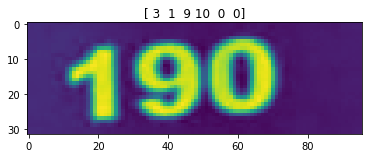

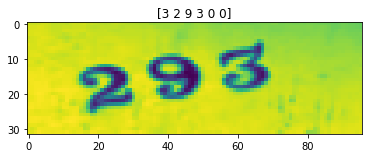

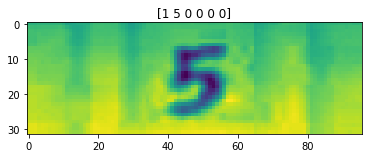

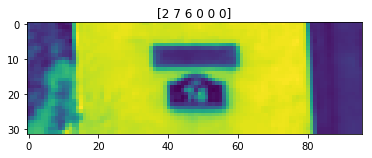

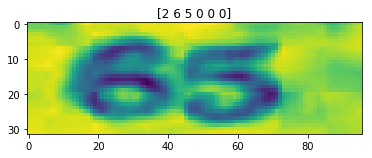

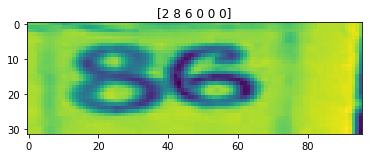

In [7]:
plot(0)
plot(123)

plot(0,1)
plot(123,1)

plot(0,2)
plot(123,2)

In [8]:
def get_label_dist(labels_data):
    ddict = {}
    for i in range(labels_data.shape[0]):
        l = labels_data[i][0]
        if not l in ddict:
            ddict[l] = 0
        ddict[l] = ddict[l] + 1
    return ddict

In [9]:
def hist_dict(dict) :
    dict = OrderedDict(sorted(dict.items()))
    X = np.arange(len(dict))
    pl.bar(X, dict.values(), align='center', width=0.5)
    pl.xticks(X, dict.keys())
    ymax = max(dict.values()) + 1000
    pl.ylim(0, ymax)
    pl.show()

In [10]:
train_label_dict = get_label_dist(train_labels)
test_label_dict = get_label_dist(test_labels)
valid_label_dict = get_label_dist(valid_labels)

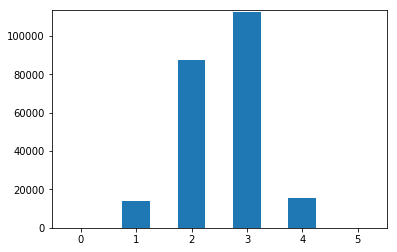

In [11]:
hist_dict(train_label_dict)

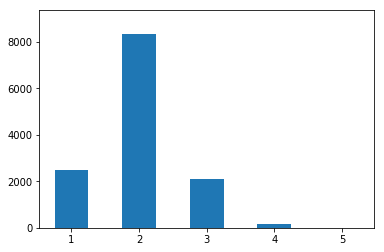

In [12]:
hist_dict(test_label_dict)

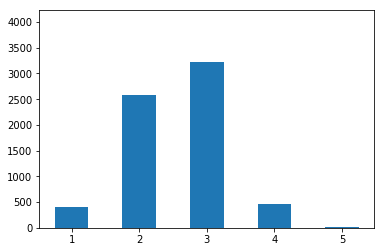

In [13]:
hist_dict(valid_label_dict)

In [14]:
train_dataset = train_dataset.astype(np.float32)
test_dataset = test_dataset.astype(np.float32)
valid_dataset = valid_dataset.astype(np.float32)

train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)
valid_labels = valid_labels.astype(np.int32)

In [15]:
model_to_save = "saved_models/multi/CNN_SVHN_Multi.ckpt"

In [16]:
graph_svhn = tf.Graph()

with graph_svhn.as_default():
    HEIGHT = 32
    WIDTH = 32*3
    
    X = tf.placeholder(tf.float32, [None, HEIGHT, WIDTH, 1], name="X")
    Y_ = tf.placeholder(tf.int32, [None, 6], name="Y")
    
    # Learning Rate - alpha
    alpha = tf.placeholder(tf.float32)
    
    # Dropout Probablity
    pkeep = tf.placeholder(tf.float32)
    
    # 5 Layers and their no of neurons
    # 3 Convolutional Layers and a fully connected layer
    K = 6     # First Conv Layer with depth 6
    L = 12     # Second Conv Layer with depth 12
    M = 24    # Third Conv layer with depth 24
    N = 200   # Fourth Fully Connected layer with 200 neurons
    # Last one will be softmax layer with 10 output channels
    
    W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1), name="W1")    # 6x6 patch, 1 input channel, K output channels
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]), name="B1")
    
    W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1), name="W2")
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]), name="B2")
    
    W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1), name="W3")
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]), name="B3")
    
    W5_1 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_1")
    B5_1 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_1")
    
    W5_2 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_2")
    B5_2 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_2")
    
    W5_3 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_3")
    B5_3 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_3")
    
    W5_4 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_4")
    B5_4 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_4")
    
    W5_5 = tf.Variable(tf.truncated_normal([N, 11], stddev=0.1), name="W5_5")
    B5_5 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_5")
    
    # Model
    stride = 1  # output is 32x96
    Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
    
    stride = 2  # output is 16x48
    Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
    
    stride = 2  # output is 8x24
    Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

    # reshape the output from the third convolution for the fully connected layer
    shape = Y3.get_shape().as_list()
    YY = tf.reshape(Y3, shape=[-1, shape[1] * shape[2] * shape[3]])
    
    W4 = tf.Variable(tf.truncated_normal([shape[1] * shape[2] * shape[3], N], stddev=0.1), name="W4")
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]), name="B4")

    Y4 = tf.sigmoid(tf.matmul(YY, W4) + B4)
    YY4 = tf.nn.dropout(Y4, pkeep)
    
    Ylogits_1 = tf.matmul(YY4, W5_1) + B5_1
    Ylogits_2 = tf.matmul(YY4, W5_2) + B5_2
    Ylogits_3 = tf.matmul(YY4, W5_3) + B5_3
    Ylogits_4 = tf.matmul(YY4, W5_4) + B5_4
    Ylogits_5 = tf.matmul(YY4, W5_5) + B5_5   
    ## ('Ylogits_1 shape : ', [None, 11])
    
    Y_1 = tf.nn.softmax(Ylogits_1)
    Y_2 = tf.nn.softmax(Ylogits_2)
    Y_3 = tf.nn.softmax(Ylogits_3)
    Y_4 = tf.nn.softmax(Ylogits_4)
    Y_5 = tf.nn.softmax(Ylogits_5)

#     tf.summary.histogram("W1_summ", W1)
#     tf.summary.histogram("W2_summ", W2)
#     tf.summary.histogram("W3_summ", W3)
#     tf.summary.histogram("W4_summ", W4)
#     tf.summary.histogram("W5_1_summ", W5_1)
#     tf.summary.histogram("W5_2_summ", W5_2)
#     tf.summary.histogram("W5_3_summ", W5_3)
#     tf.summary.histogram("W5_4_summ", W5_4)
#     tf.summary.histogram("W5_5_summ", W5_5)

#     tf.summary.scalar('W1', W1)
#     tf.summary.scalar('W2', W2)
#     tf.summary.scalar('W3', W3)
#     tf.summary.scalar('W4', W4)
    

    with tf.name_scope('cross_entropy'):
        cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_1, Y_[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_2, Y_[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_3, Y_[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_4, Y_[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_5, Y_[:,5]))
#     tf.summary.scalar('cross_entropy', cross_entropy)
    
    train_prediction = tf.pack([Y_1, Y_2, Y_3, Y_4, Y_5])
    
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(alpha).minimize(cross_entropy)
    
    W_s = tf.pack([tf.reduce_max(tf.abs(W1)),tf.reduce_max(tf.abs(W2)),tf.reduce_max(tf.abs(W3)),tf.reduce_max(tf.abs(W4))])
    b_s = tf.pack([tf.reduce_max(tf.abs(B1)),tf.reduce_max(tf.abs(B2)),tf.reduce_max(tf.abs(B3)),tf.reduce_max(tf.abs(B4))])
    
#     merged = tf.summary.merge_all()
#     train_writer = tf.train.SummaryWriter(FLAGS.summaries_dir + '/train',sess.graph)
    
    model_saver = tf.train.Saver()

In [18]:
train_data = train_dataset
label_data = train_labels
print('train : ', train_data.shape, '  test : ', label_data.shape)

batch_size = 128

num_steps = int(label_data.shape[0] / batch_size)

# num_epochs = int(train_labels.shape[0] / batch_size)
num_epochs = 15

with tf.Session(graph=graph_svhn) as session:
    tf.global_variables_initializer().run()
#     model_saver.restore(session, saved_model)
    print('Initialized')
    
    for epoch in range(num_epochs-1) :
        test_d = test_dataset[epoch*batch_size:(epoch+1)*batch_size,:,:,:]
        test_l = test_labels[epoch*batch_size:(epoch+1)*batch_size,:]
        
        for step in range(num_steps-1):
            
            #  learning rate decay
            max_learning_rate = 0.00005
            min_learning_rate = 0.00001

#             max_learning_rate = 0.0000
#             min_learning_rate = 0.0000

            decay_speed = 5000.0
            learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-step/decay_speed)
            
            batch_data = train_data[step*batch_size:(step + 1)*batch_size, :, :, :]
            batch_labels = label_data[step*batch_size:(step + 1)*batch_size, :]

            feed_dict = {X : batch_data, Y_ : batch_labels, pkeep : 0.80, alpha : learning_rate}
            _, l, train_pred, W, b = session.run([train_step, cross_entropy, train_prediction, W_s, b_s], feed_dict=feed_dict)
            accu = acc(train_pred, batch_labels[:,1:6])
            
            if (step % 500 == 0):
                print('epoch : ',epoch+1, ' => ', 'Loss at step %d: %f' % (step, l))
                print('epoch : ',epoch+1, ' => ', 'Minibatch accuracy: %.1f%%' % accu)
                print('epoch : ',epoch+1, ' => ', 'Learning rate : ', learning_rate)
                print('W : ', W)
                print('b : ', b)
                print('    ')
        print('------------------------------------------')
        feed_dict = {X : test_d, Y_ : test_l, pkeep : 1.00, alpha : 0.0005}
        _, l, test_pred, W, b = session.run([train_step, cross_entropy, train_prediction, W_s, b_s], feed_dict=feed_dict)
        
        print('Epoch Test accuracy: %.1f%%' % acc(test_pred, test_l[:,1:6]))
        print('Epoch W_s : ', W)
        print('Epoch b_s : ', b)
        print('------------------------------------------')
        print('      ')
                
    print('Training Complete on MNIST Data')    
    save_path = model_saver.save(session, model_to_save)
    print("Model saved in file: %s" % save_path)

train :  (229089, 32, 96, 1)   test :  (229089, 6)
Initialized
epoch :  1  =>  Loss at step 0: 13.353888
epoch :  1  =>  Minibatch accuracy: 7.7%
epoch :  1  =>  Learning rate :  5e-05
W :  [ 0.18687578  0.19975206  0.19995028  0.19999933]
b :  [ 0.1  0.1  0.1  0.1]
    
epoch :  1  =>  Loss at step 500: 6.742727
epoch :  1  =>  Minibatch accuracy: 56.4%
epoch :  1  =>  Learning rate :  4.6193496721438385e-05
W :  [ 0.1931776   0.20378442  0.20436697  0.20801727]
b :  [ 0.10812092  0.10646755  0.10546628  0.10452136]
    
epoch :  1  =>  Loss at step 1000: 6.911223
epoch :  1  =>  Minibatch accuracy: 54.5%
epoch :  1  =>  Learning rate :  4.274923012311928e-05
W :  [ 0.19744842  0.20973726  0.2084509   0.2180296 ]
b :  [ 0.10929793  0.10837038  0.10662459  0.10461385]
    
epoch :  1  =>  Loss at step 1500: 6.494378
epoch :  1  =>  Minibatch accuracy: 57.5%
epoch :  1  =>  Learning rate :  3.9632728827268715e-05
W :  [ 0.20167178  0.22210141  0.21574686  0.22695915]
b :  [ 0.11241276  

KeyboardInterrupt: 

In [19]:
train_data = train_dataset
label_data = train_labels
print('train : ', train_data.shape, '  test : ', label_data.shape)

multi_train_dict = {}
batch_size = 128
num_steps = int(label_data.shape[0] / batch_size)
num_epochs = 25

with tf.Session(graph=graph_svhn) as session:
    tf.global_variables_initializer().run()
    print('Initialized')

    test_batch = int(test_labels.shape[0]/num_epochs)
    test_acc = list()
    
    for epoch in range(num_epochs - 1):
        res_epoch = {}
        t_data = test_dataset[epoch*test_batch:(epoch+1)*test_batch]
        t_label = test_labels[epoch*test_batch:(epoch+1)*test_batch]
        
        for step in range(num_steps - 1):
            max_learning_rate = 0.0005
            min_learning_rate = 0.0001

            decay_speed = 5000.0
            learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-step/decay_speed)

            batch_data = train_data[step*batch_size:(step + 1)*batch_size, :, :, :]
            batch_labels = label_data[step*batch_size:(step + 1)*batch_size, :]

            feed_dict = {X : batch_data, Y_ : batch_labels, pkeep : 0.80, alpha : learning_rate}
            _, l, train_pred, W, b = session.run([train_step, cross_entropy, train_prediction, W_s, b_s], feed_dict=feed_dict)
            accuracy = float(acc(train_pred, batch_labels[:,1:6]))

            if (step % 500 == 0):
                minibatch = {}
                minibatch['loss'] = l
                minibatch['W'] = W
                minibatch['B'] = b
                minibatch['accuracy'] = "%.2f" % accuracy

                res_epoch[int(step/500)] = minibatch
                print('Loss at step %d: %f' % (step, l))
                print('Minibatch accuracy: %.1f%%' % acc(train_pred, batch_labels[:,1:6]))
                print('    ')
                
        multi_train_dict[epoch+1] = res_epoch

        epoch_acc = 0
        for f in res_epoch:
            minibatch = res_epoch[f]
            epoch_acc += float(minibatch['accuracy'])
        epoch_acc = float(epoch_acc/len(res_epoch))
        
        _, l, predictions = session.run([train_step, cross_entropy, train_prediction], feed_dict={X : t_data, Y_ : t_label, pkeep : 1.0, alpha : 0.002})
        accuracy = float(acc(predictions, t_label[:,1:6]))
        test_acc.append(accuracy)

        print('------------------------------------')
        print('Epoch',epoch+1,' Complete with accuracy: %.2f%%' % epoch_acc)
        print('Epoch',epoch+1,' Test Accuracy : %.2f%%' % accuracy)
        print('------------------------------------')
        print('        ')
            
    print('Training Complete on MNIST Data')
    print('Test Accuracy : ', mean(test_acc))
    
    save_path = model_saver.save(session, model_to_save)
    print("Model saved in file: %s" % save_path)

train :  (229089, 32, 96, 1)   test :  (229089, 6)
Initialized
Loss at step 0: 12.492880
Minibatch accuracy: 18.8%
    
Loss at step 500: 5.500284
Minibatch accuracy: 64.8%
    
Loss at step 1000: 4.608907
Minibatch accuracy: 71.4%
    
Loss at step 1500: 3.951681
Minibatch accuracy: 75.9%
    
------------------------------------
Epoch 1  Complete with accuracy: 57.73%
Epoch 1  Test Accuracy : 69.81%
------------------------------------
        
Loss at step 0: 3.994959
Minibatch accuracy: 75.0%
    
Loss at step 500: 3.263086
Minibatch accuracy: 80.8%
    
Loss at step 1000: 3.417358
Minibatch accuracy: 79.5%
    
Loss at step 1500: 2.885538
Minibatch accuracy: 82.0%
    
------------------------------------
Epoch 2  Complete with accuracy: 79.34%
Epoch 2  Test Accuracy : 72.84%
------------------------------------
        
Loss at step 0: 3.031461
Minibatch accuracy: 82.2%
    
Loss at step 500: 2.506552
Minibatch accuracy: 85.0%
    
Loss at step 1000: 2.870907
Minibatch accuracy: 

In [20]:
file = 'results/Multi.pickle'

with open(file, 'wb') as handle:
    pickle.dump(multi_train_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
with tf.Session(graph=graph_svhn) as session: 
    print('Initialized')
    batch = 1000
    
    valid_acc = list()
    valid_no = int(valid_dataset.shape[0] /  batch)
    for i in range(valid_no - 1):
        model_saver.restore(session, model_to_save)
        data = valid_dataset[i*batch:(i+1)*batch]
        labels = valid_labels[i*batch:(i+1)*batch]
        
        _, l, predictions = session.run([train_step, cross_entropy, train_prediction], feed_dict={X : data, Y_ : labels, pkeep : 1.0, alpha : 0.002})
        accuracy = acc(predictions, labels[:,1:6])
        valid_acc.append(accuracy)
        
        print('Valid-Accuracy', ' Batch : ', i*1000)
        print('Valid accuracy: ', accuracy)
        print('        ')
            
    valid_avg = mean(valid_acc)
    
    print('-----  FINAL  ------')
    print('Final Validation Set Accuracy : ',"%.2f" % valid_avg)

Initialized
Valid-Accuracy  Batch :  0
Valid accuracy:  88.74
        
Valid-Accuracy  Batch :  1000
Valid accuracy:  88.78
        
Valid-Accuracy  Batch :  2000
Valid accuracy:  89.1
        
Valid-Accuracy  Batch :  3000
Valid accuracy:  88.3
        
Valid-Accuracy  Batch :  4000
Valid accuracy:  88.1
        
-----  FINAL  ------
Final Validation Set Accuracy :  88.60
